In [35]:
import pandas as pd
import numpy as np

df = pd.read_csv("judge-1377884607_tweet_product_company.csv", encoding='latin1')

## Data Exploration and Cleaning

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [37]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [38]:
#set display options to see all data
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 50)

In [39]:
#create a function to determine whether a tweet refers to Apple or Google 
def company(product):
    apple_prods = ['ipad', 'apple', 'iphone']
    google_prods = ['google', 'other google product or service', 'android app', 'android']
    if any(item in str(product).lower() for item in apple_prods):
        return 'Apple'
    elif any(item in str(product).lower() for item in google_prods):
        return 'Google'
    else:
        return 'Unknown'

#apply function to create new column
df['Company'] = df['emotion_in_tweet_is_directed_at'].apply(lambda x: company(x))


In [40]:
#drop Google tweets
df = df[df['Company'] != 'Google']

In [41]:
df['Company'].value_counts()

Unknown    5802
Apple      2409
Name: Company, dtype: int64

In [42]:
df = df[(df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion') | (df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion')]

In [43]:
#simplify column names
df.columns = ['text', 'subject', 'emotion', 'company']

In [44]:
df['subject'].value_counts()

iPad                              918
Apple                             638
iPad or iPhone App                460
iPhone                            287
Other Apple product or service     34
Name: subject, dtype: int64

In [45]:
df['subject'].info()

<class 'pandas.core.series.Series'>
Int64Index: 2694 entries, 0 to 9088
Series name: subject
Non-Null Count  Dtype 
--------------  ----- 
2337 non-null   object
dtypes: object(1)
memory usage: 42.1+ KB


In [46]:
# Impute missing values in emotion column
def find_product(tweet):
    tweet = tweet.lower()
    product = None
    if ' app' in tweet: 
        product = 'iPad or iPhone App'
    elif 'ipad' in tweet: 
        product = 'iPad'
    elif 'iphone' in tweet:
        product = 'iPhone'
    elif 'apple' in tweet:
        product_list = 'Apple'
    return product

In [47]:
#apply function to null values 
mask = df['subject'].isnull()
df.loc[mask, 'subject'] = df.loc[mask, 'text'].apply(find_product)

In [48]:
df.dropna(subset='subject', inplace=True)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2560 entries, 0 to 9088
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     2560 non-null   object
 1   subject  2560 non-null   object
 2   emotion  2560 non-null   object
 3   company  2560 non-null   object
dtypes: object(4)
memory usage: 100.0+ KB


In [50]:
#clean emotion column
df['emotion'] = df['emotion'].apply(lambda x: x.split(' ')[0])

In [51]:
#look at split of our data
df['emotion'].value_counts()

Positive    2141
Negative     419
Name: emotion, dtype: int64

In [52]:
df.drop('company', axis=1, inplace=True)

## Data Pre-Processing

In [53]:
from nltk.corpus import stopwords
from nltk import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
import string
import re


In [54]:

#define our preprocessing function
def text_preprocessing(tweet):
    tweet_cleaned = re.sub(r'@\w+', '', tweet)
    tweet_cleaned = re.sub(r'http://\S+', '', tweet_cleaned)
    pattern = "([a-zA-Z\d]+(?:'[a-z\d]+)?)"
    tokenizer = RegexpTokenizer(pattern)
    tokens = tokenizer.tokenize(tweet_cleaned)
    stop_words_list = stopwords.words('english')
    stop_words_list += ['sxsw', 'link', 'rt', 'quot']
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words_list]
    lemmatizer = WordNetLemmatizer()
    lemmed_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmed_tokens




In [55]:
df['text'][19]

'Must have #SXSW app! RT @malbonster: Lovely review from Forbes for our SXSW iPad app Holler Gram - http://t.co/g4GZypV'

In [56]:
#test on one tweet
tester = df['text'][19]
test_tokens = text_preprocessing(tester)

test_tokens

['must', 'app', 'lovely', 'review', 'forbes', 'ipad', 'app', 'holler', 'gram']

### Apply the pre-processing function to our dataframe

In [57]:
df['tokens'] = df['text'].apply(text_preprocessing)

In [58]:
df.head(20)

,text,subject,emotion,tokens
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,"[3g, iphone, 3, hr, tweeting, rise, austin, dead, need, upgrade, plugin, station]"
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,"[know, awesome, ipad, iphone, app, likely, appreciate, design, also, they're, giving, free, t]"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,"[wait, ipad, 2, also, sale]"
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,"[hope, year's, festival, crashy, year's, iphone, app]"
8,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,iPad or iPhone App,Positive,"[beautifully, smart, simple, idea, wrote, hollergram, ipad, app]"
9,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive,"[counting, day, plus, strong, canadian, dollar, mean, stock, apple, gear]"
14,Great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l,iPad or iPhone App,Positive,"[great, ipad, app]"
15,"haha, awesomely rad iPad app by @madebymany http://bit.ly/hTdFim #hollergram #sxsw",iPad or iPhone App,Positive,"[haha, awesomely, rad, ipad, app, hollergram]"
17,I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone,iPhone,Negative,"[noticed, dst, coming, weekend, many, iphone, user, hour, late, come, sunday, morning, iphone]"
18,"Just added my #SXSW flights to @planely. Matching people on planes/airports. Also downloaded the @KLM iPhone app, nicely done.",iPad or iPhone App,Positive,"[added, flight, matching, people, plane, airport, also, downloaded, iphone, app, nicely, done]"


In [59]:
#create a set of unique tokens 
token_set = []
for tokens in df['tokens'].values:
    for token in tokens: 
        token_set.append(token)

len(set((token_set)))


4365

In [60]:
#we have 4,365 unique lemmed tokens 

In [61]:
df.groupby(['subject', 'emotion']).count()

text  tokens
subject                        emotion               
Apple                          Negative    95      95
                               Positive   543     543
Other Apple product or service Negative     2       2
                               Positive    32      32
iPad                           Negative   135     135
                               Positive   862     862
iPad or iPhone App             Negative    76      76
                               Positive   486     486
iPhone                         Negative   111     111
                               Positive   218     218

In [62]:
#convert to lemmed token format
def format_lem(tokens):
    return ' '.join(tokens)

df['formatted_lemmed_text'] = df['tokens'].apply(format_lem)

In [63]:
sample = df[df['emotion'] == 'Negative'].sample(n = 10)

sample['text'].values

array(['Opened yesterday. Line too long to wait in just to look. #SXSW #sxswi @mention Apple Store, SXSW {link}',
       "Tablets like the iPad and Xoom where touch emulates a mouse-click/keyboard input means we're not there yet. #sxsw #gswsxsw #futureoftouch",
       "It's not all Apple love here at #sxsw. Heard quite a bit of grumbling about holding back features on iPad 1 so people would have to buy v2.",
       'I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone',
       'wow you suck {link} iPad #sxsw Rebecca Black #fab5',
       'Tomlinson of TX Observer says Apple subscription data holding is biggest impediment to success. #newsapps #sxsw',
       "I'm up to 2 iPad 2s seen in the wild. Both people say it is fast, but the still pics are terrible. #sxsw",
       '.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
       'My fr

## Visualize Tokens with Frequency Dsitribution and Word Clouds

In [64]:
from nltk.probability import FreqDist

#positive tweets
df_pos = df[df['emotion'] == 'Positive']
positive_tokens = [token for tokens in df_pos['tokens'].values for token in tokens]
pos_freq_dist = FreqDist(positive_tokens)

df_neg = df[df['emotion'] == 'Negative']
negative_tokens = [token for tokens in df_neg['tokens'].values for token in tokens]
neg_freq_dist = FreqDist(negative_tokens)


In [98]:
neg_string = ' '.join(negative_tokens)
wc_neg = WordCloud()
wc_neg.generate(neg_string)

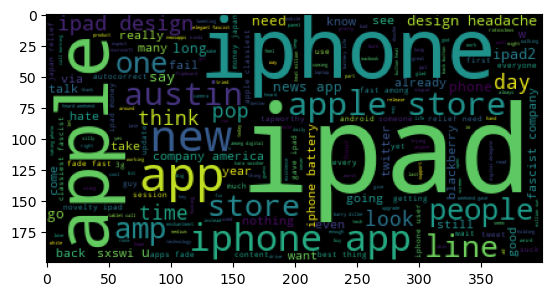

In [99]:
plt.imshow(wc_neg)
plt.show()

In [65]:
#Look at most positive product tweets and least positive product 
#make this a function
df_iphone_neg = df[(df['subject'] == 'iPhone') & (df['emotion'] == 'Negative')]
iphone_neg_tokens = [token for tokens in df_iphone_neg['tokens'].values for token in tokens]
iphone_neg_freq_dist = FreqDist(iphone_neg_tokens)
iphone_neg_freq_dist.most_common()

[('iphone', 111),
 ('battery', 16),
 ('austin', 12),
 ('amp', 11),
 ('time', 9),
 ('blackberry', 8),
 ('go', 8),
 ('know', 7),
 ('already', 7),
 ('app', 7),
 ('phone', 7),
 ('user', 6),
 ('going', 6),
 ('like', 6),
 ('many', 5),
 ('hour', 5),
 ('say', 5),
 ('apple', 5),
 ('people', 5),
 ('one', 5),
 ('think', 5),
 ('would', 5),
 ('u', 5),
 ('life', 5),
 ('good', 5),
 ('3g', 4),
 ('3', 4),
 ('need', 4),
 ('android', 4),
 ("i'm", 4),
 ('panel', 4),
 ('back', 4),
 ('ipad', 4),
 ('4', 4),
 ('mobile', 4),
 ('store', 4),
 ('shit', 4),
 ('last', 4),
 ('long', 4),
 ('made', 4),
 ('technology', 4),
 ('always', 4),
 ('fail', 4),
 ('working', 4),
 ('new', 4),
 ('get', 4),
 ('anything', 4),
 ('forward', 4),
 ('tweeting', 3),
 ('dead', 3),
 ('late', 3),
 ('come', 3),
 ('alarm', 3),
 ('flight', 3),
 ('also', 3),
 ('stupid', 3),
 ('even', 3),
 ("can't", 3),
 ('tweet', 3),
 ('getting', 3),
 ('brick', 3),
 ('help', 3),
 ('ever', 3),
 ('never', 3),
 ('could', 3),
 ('much', 3),
 ("iphone's", 3),
 ('usefu

In [66]:
df_ipad_pos = df[(df['subject'] == 'iPad') & (df['emotion'] == 'Positive')]
ipad_pos_tokens = [token for tokens in df_ipad_pos['tokens'].values for token in tokens]
ipad_pos_freq_dist = FreqDist(ipad_pos_tokens)
ipad_pos_freq_dist.most_common()

[('ipad', 771),
 ('2', 368),
 ('apple', 228),
 ('store', 182),
 ('ipad2', 127),
 ('austin', 93),
 ('new', 76),
 ('line', 72),
 ('pop', 68),
 ('get', 56),
 ("i'm", 52),
 ('win', 52),
 ('one', 52),
 ('day', 38),
 ('first', 37),
 ('want', 36),
 ('amp', 34),
 ('got', 34),
 ('like', 33),
 ('video', 33),
 ('sxswi', 32),
 ('via', 32),
 ('need', 31),
 ('great', 30),
 ('launch', 30),
 ('time', 30),
 ('design', 28),
 ('popup', 27),
 ('take', 27),
 ('go', 27),
 ('buy', 25),
 ('case', 25),
 ('thing', 23),
 ('going', 22),
 ('year', 22),
 ('awesome', 22),
 ('wait', 21),
 ('check', 21),
 ("2's", 21),
 ('today', 21),
 ('away', 21),
 ('ipads', 21),
 ('really', 21),
 ('come', 21),
 ('look', 21),
 ('around', 20),
 ('free', 20),
 ('giving', 20),
 ('w', 19),
 ('downtown', 19),
 ('people', 19),
 ('panel', 19),
 ('party', 18),
 ('sold', 18),
 ('good', 18),
 ('winning', 18),
 ('laptop', 18),
 ('next', 18),
 ('best', 17),
 ('coming', 17),
 ('temporary', 17),
 ('tapworthy', 17),
 ('see', 17),
 ('guy', 17),
 ("i

### Create WordClouds to explore the most important words in our tweet subsets

In [67]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [90]:
neg_cloud_X = df_neg['formatted_lemmed_text']
neg_cloud_vec = TfidfVectorizer()
X_vec = neg_cloud_vec.fit_transform(neg_cloud_X)


In [95]:
feature_names = neg_cloud_vec.get_feature_names_out()
dense = X_vec.todense()
denselist = dense.tolist()
neg_cloud_df = pd.DataFrame(denselist, columns=feature_names)

neg_cloud_df.head()

,000,10,100,100tc,101,10am,10k,10mins,10x,11,...,year,yes,yesterday,yet,yonkers,york,zelda,zeldman,zone,zzzs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.653082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


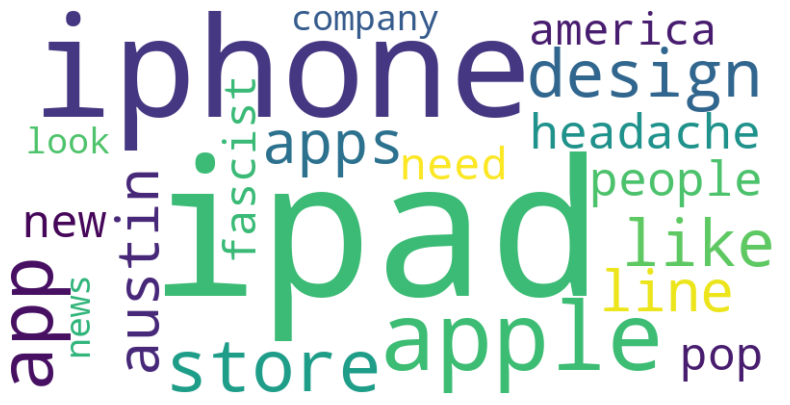

In [103]:
#Create a negative tweet word cloud 
tfidf_scores = np.asarray(X_vec.mean(axis=0)).ravel()
df_tfidf = pd.DataFrame({'Word': feature_names, 'TF-IDF': tfidf_scores})
df_tfidf = df_tfidf.sort_values(by='TF-IDF', ascending=False)
word_tfidf_dict = df_tfidf.set_index('Word')['TF-IDF'].to_dict()
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=20)
wordcloud.generate_from_frequencies(word_tfidf_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

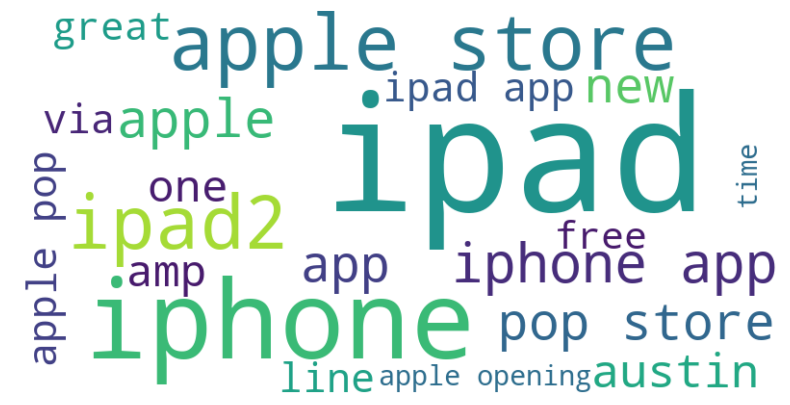

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

In [104]:
#Create a positive tweet word cloud 
pos_string = ' '.join(positive_tokens)
pos_wc = WordCloud(width=800, height=400, background_color='white', max_words=20)
pos_wc.generate(pos_string)



plt.figure(figsize=(10, 5))
plt.imshow(pos_wc, interpolation='bilinear')
plt.axis('off')
plt.show()
plt.imshow

In [ ]:
pos_ipad = df[(df['subject'] == "iPad") & (df['emotion'] == 'Positive')]
pos_

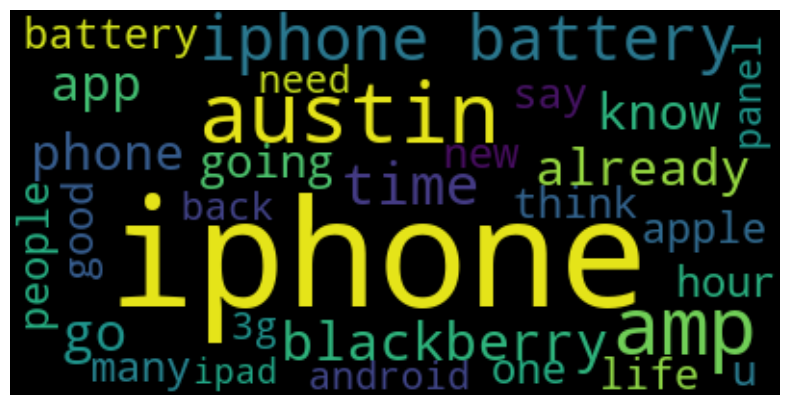

In [105]:
#look at negative iPhone tweets
iphone_neg_string = " ".join(iphone_neg_tokens)
iphone_neg_wc = WordCloud(max_words=30)
iphone_neg_wc.generate_from_text(iphone_neg_string)

plt.figure(figsize=(10, 5))
plt.imshow(iphone_neg_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## supplement data with additional negative tweets from Chat-GPT 
Our goal is at least 70-30 split, so we would need 

In [68]:
#get samples to train Chat-GPT on 
sample = df[df['emotion'] == 'Negative'].sample(n = 10)

sample['text'].values

array(['Boooo! RT @mention Flipboard is developing an iPhone version, not Android, says @mention #sxsw',
       'SXSW iPhone app is awesome, but iPad app crashes every time. #sxsw',
       'iPhone battery is going quickly. Guy behind me let me borrow his portable charger. I want one! {link} #SXSW',
       'Will I survive #SXSW will only 1.6 gigs of space left on my iPhone? We shall see.',
       "Nothing says DOUCHE CAKE like walking around with a IPAD like it's an Iphone #sxsw",
       '#SXSW 2011: Novelty of #iPad news apps fades fast among digital delegates {link} via @mention',
       "Andrew K of PRX equates the homogeneity of the Apple ecosystem w predictability, vs Android's wild west. #imaconf #sxsw #drumbeat #MoJo",
       '#iPad design/UI tip: \x89ÛÏbuttons are a hack -approach them with skepticism \x89ÛÏ #tapworthy #sxsw',
       "@mention love what y'all do at #SXSW. How come I'm getting login authorization error almost every time I open my app on iPhone?",
       '\x89ÛÏTh

In [69]:
#read in our supplementary tweets
CG_tweets_Maddie = pd.read_csv("cg_tweets_final.csv")
CG_tweets_Steven = pd.read_csv("chatgpt_tweets.csv")

CG_tweets_Steven['emotion'] = 'Negative'
CG_tweets_Steven.columns = ['text', 'emotion']
CG_tweets_Maddie.columns = ['text', 'emotion']

CG_tweets = pd.concat([CG_tweets_Maddie, CG_tweets_Steven], ignore_index=True)

CG_tweets['tokens'] = CG_tweets['text'].apply(text_preprocessing)

#convert to lemmed token format
CG_tweets['formatted_lemmed_text'] = CG_tweets['tokens'].apply(format_lem)


In [70]:
CG_tweets.shape

(1313, 4)

In [71]:
CG_tweets.duplicated(subset='text').sum()
CG_tweets.drop_duplicates(subset='text', inplace=True)

#### Add our Chat GPT Tweets to our original dataframe

In [72]:
df_full = pd.concat([df, CG_tweets], ignore_index=True)

In [73]:
df_full.duplicated(subset='text').sum()

8

In [74]:
df_full.drop_duplicates(subset='text', inplace=True)

In [75]:
df_full.tail()

,text,subject,emotion,tokens,formatted_lemmed_text
3541,About to learn all about design headaches for iPad. Can't wait to gain some insights! #sxsw,NaN,Negative,"[learn, design, headache, ipad, can't, wait, gain, insight]",learn design headache ipad can't wait gain insight
3542,Barry Diller says iPad-only magazines like The Daily don't make sense. #sxsw,NaN,Negative,"[barry, diller, say, ipad, magazine, like, daily, make, sense]",barry diller say ipad magazine like daily make sense
3543,Barry Diller believes writing content for one form factor only is silly; Apple likes it because they get money. #SXSW,NaN,Negative,"[barry, diller, belief, writing, content, one, form, factor, silly, apple, like, get, money]",barry diller belief writing content one form factor silly apple like get money
3544,Barry Diller's pragmatic and straightforward approach is refreshing. Ready to grab pitchforks against Apple! #SXSW,NaN,Negative,"[barry, diller's, pragmatic, straightforward, approach, refreshing, ready, grab, pitchfork, apple]",barry diller's pragmatic straightforward approach refreshing ready grab pitchfork apple
3545,So many people at #SXSW with iPad 1s. No shame in not having,NaN,Negative,"[many, people, ipad, 1, shame]",many people ipad 1 shame


In [76]:
data = df_full[['formatted_lemmed_text', 'emotion']]

In [77]:
#write our training data into a separate CSV
data.to_csv('training_data.csv', index=False)

## Perform a train-test-split

In [78]:
from sklearn.model_selection import train_test_split

In [79]:
data['emotion'] = data['emotion'].map({"Negative": 1, "Positive": 0})

/var/folders/qh/ns54bt951q74xt4l68nw_m840000gn/T/ipykernel_10697/3082815462.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['emotion'] = data['emotion'].map({"Negative": 1, "Positive": 0})


In [80]:
data.head()

,formatted_lemmed_text,emotion
0,3g iphone 3 hr tweeting rise austin dead need upgrade plugin station,1
1,know awesome ipad iphone app likely appreciate design also they're giving free t,0
2,wait ipad 2 also sale,0
3,hope year's festival crashy year's iphone app,1
4,beautifully smart simple idea wrote hollergram ipad app,0


In [81]:
target = data['emotion']
text = data['formatted_lemmed_text']

text_train, text_test, target_train, target_test = train_test_split(text, target, stratify=target, random_state=42)

In [82]:
target_train.value_counts(normalize=True)

0    0.603845
1    0.396155
Name: emotion, dtype: float64

In [83]:
target_test.value_counts(normalize=True)

0    0.60452
1    0.39548
Name: emotion, dtype: float64

### Create bag of words framework with CountVectorizer 

In [84]:
#from sklearn.feature_extraction.text import CountVectorizer 
#vectorizer = CountVectorizer(min_df=4)
#X_train = vectorizer.fit_transform(text_train)
#text_train_vec = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out())
#df_merged = pd.concat([text_train, text_train_vec], join='inner', axis=1)



### Use TF-IDF Vectorizer

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(text_train).toarray()
X_test = vectorizer.transform(text_test).toarray()

In [86]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import xgboost as xgb

In [87]:
#establish our baseline XGBoost model 

clf = xgb.XGBClassifier()
clf.fit(X_train, target_train)
train_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

baseline_training_accuracy = accuracy_score(target_train, train_preds)
baseline_test_accuracy = accuracy_score(target_test, test_preds)


In [88]:
#Baseline acuracy scores 
print(baseline_training_accuracy)
print(baseline_test_accuracy)

0.9329061439879381
0.8497175141242937


In [106]:
recall_score(target_test, test_preds)

0.7714285714285715

### Tune our XGBoost with GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.2, 0.3],
    'max_depth': [3, 6],
    'subsample': [0.5, 0.7],
    'min_child_weight': [1, 2],
    'n_estimators': [100, 120],
}
grid_clf = GridSearchCV(clf, param_grid=param_grid, scoring='accuracy')
grid_clf.fit(X_train, target_train)

best_parameters = grid_clf.best_params_

In [ ]:
best_parameters

In [ ]:

best_train_preds = grid_clf.predict(X_train)
best_test_preds = grid_clf.predict(X_test)

In [ ]:
accuracy_score(target_test, best_test_preds)